In [ ]:
!pip install comet_ml

In [ ]:
!pip install catboost

In [3]:
from comet_ml import Experiment
from comet_ml import API
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import classification_report, PrecisionRecallDisplay, brier_score_loss
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import os
import pickle
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [5]:
with open('COMET_API_KEY.txt', 'r') as f:
    key = f.read()
# Create an experiment with your api key
experiment = Experiment(
    api_key=key,
    project_name="nhl-data-science",
    workspace="mahmoodhegazy",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/mahmoodhegazy/nhl-data-science/5457fb6c2cbd4947a8dc7c8b46d3e2c8



In [6]:
def download_model(workspace,model_name,version):
    if not os.path.exists('comet_models/'):
        os.mkdir('comet_models/')
    api = API(api_key=key)
    api.download_registry_model(workspace=workspace,registry_name=model_name, version=version,
    output_path='./comet_models', expand=True)

Model=['angle-model-1','distance-model-1','distance-and-angle-model-1', 'XGBoost', 'cat-boost-clf-new']
for i in Model :
    download_model('mahmoodhegazy',i,'1.0.0')

COMET INFO: Downloading registry model 'angle-model-1', version '1.0.0', stage None from workspace 'mahmoodhegazy'...
COMET INFO: Unzipping model to '/content/comet_models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'distance-model-1', version '1.0.0', stage None from workspace 'mahmoodhegazy'...
COMET INFO: Unzipping model to '/content/comet_models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'distance-and-angle-model-1', version '1.0.0', stage None from workspace 'mahmoodhegazy'...
COMET INFO: Unzipping model to '/content/comet_models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'XGBoost', version '1.0.0', stage None from workspace 'mahmoodhegazy'...
COMET INFO: Unzipping model to '/content/comet_models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'cat-boost-clf-new', version '1.0.0', stage None from workspace 'mahmoodhegazy'...
COMET INFO: Unzipping model to '/content/comet_models' ...
COMET INFO: done!


# Part 1:Test on 2019/20 Regular Season Dataset




In [7]:
raw_data = pd.read_csv('/content/all_game_data_milesstone_2.csv')

## Form the xgb data utils

In [8]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns


class FeatureEngineering():

    def __init__(self, path_to_tidy_data='data/all_game_data.csv'):
        """
        This class is the main class for feature Engineering, it is where the feature eng for milestone 2 lies

        Args:
        path_to_tiny_data: path to tidy data devoloped in milestone 1
        """

        self.df = pd.read_csv(path_to_tidy_data)


    def add_change_to_shot_angle(self, df):
        """
        Helper function to calculate change in shot angle
        """
        # Create a new column for the last shot angle
        df['last_shot_angle'] = df['shot_angle'].shift()
        # Initialize change_in_shot_angle with zeros
        df['change_in_shot_angle'] = 0
        # Define a mask for rows where 'rebound' is True and none of the required values are None
        valid_rebounds = df['rebound'] & df[['last_y_coordinate', 'y_coordinate', 'last_shot_angle', 'shot_angle']].notnull().all(axis=1)
        # Calculate change in shot angle for valid rebounds
        same_side = df['last_y_coordinate'] * df['y_coordinate'] >= 0  # Shots on the same side
        df.loc[valid_rebounds & same_side, 'change_in_shot_angle'] = np.abs(df['last_shot_angle'] - df['shot_angle'])
        df.loc[valid_rebounds & ~same_side, 'change_in_shot_angle'] = 180 - df['last_shot_angle'] - df['shot_angle']
        # Drop the temporary column
        df = df.drop(['last_shot_angle'], axis=1)
        return df

    def tranform(self):
        """
        Helper method for all Feature Engineering 1 transformations in milestone 2
        """
        ## Defined Transforms
        self.df['distance_to_positive_goal'] = np.sqrt((self.df['x_coordinate'] - 84)**2 + self.df['y_coordinate']**2)
        self.df['distance_to_negative_goal'] = np.sqrt((self.df['x_coordinate'] + 84)**2 + self.df['y_coordinate']**2)
        self.df['goal_coordinate'] = np.where(self.df['distance_to_positive_goal'] < self.df['distance_to_negative_goal'], 84, -84)
        self.df['shot_distance_to_goal'] = self.df[['distance_to_positive_goal', 'distance_to_negative_goal']].min(axis=1)

        # Get Angle
        # Ensure shot_distance_to_goal is not zero to avoid division by zero
        self.df['shot_distance_to_goal'] = np.where(self.df['shot_distance_to_goal'] == 0, np.nan, self.df['shot_distance_to_goal'])
        # Calculate the ratio and ensure it's within [-1, 1] to avoid invalid values for arcsin
        ratio = self.df['y_coordinate'] / self.df['shot_distance_to_goal']
        ratio = np.clip(ratio, -1, 1)
        # Calculate the shot angle
        self.df['shot_angle'] = np.where(self.df['goal_coordinate'] == 84,
                       np.arcsin(ratio) * 180 / math.pi,
                       np.arcsin(ratio) * -180 / math.pi)
        self.df['shot_angle'].fillna(0, inplace=True)
        self.df['shot_distance_to_goal'].fillna(0, inplace=True)

        self.df['is_goal'] = self.df['is_goal'].fillna(0).astype(int)
        self.df['is_emptyNet'] = self.df['is_emptyNet'].fillna(0).astype(int)
        self.df = self.add_change_to_shot_angle(self.df)


        goal_rate = self.df['is_goal'].sum() / len(self.df)
        self.df['goal_rate_dist'] = goal_rate / self.df['shot_distance_to_goal']
        self.df['goal_rate_angle'] = goal_rate / self.df['shot_angle']
        self.df['goal_rate_dist'] = self.df['goal_rate_dist'].replace([math.inf], 1)
        self.df['goal_rate_angle'] = self.df['goal_rate_angle'].replace([-math.inf], 1)
        self.df['goal_rate_angle'] = self.df['goal_rate_angle'].replace([math.inf], 1)


    def train_test_split(self, seasons_train=[20162017, 20172018, 20182019], season_test=20192020):
        df_train = self.df[self.df['season'].isin(seasons_train)]
        df_test = self.df[self.df['season'] == season_test]
        return df_train, df_test

    def adjustdata(self, train, test):
        X_cols = ['game_seconds', 'game_period', 'x_coordinate', 'y_coordinate', 'shot_distance_to_goal', 'shot_angle', 'shot_type',
        'last_x_coordinate', 'last_y_coordinate', 'last_event', 'time_from_last_event', 'distance_from_last_event', 'rebound', 'speed',
        'time_since_powerplay_started', 'num_friendly_non_goalie_skaters', 'num_opposing_non_goalie_skaters']
        y_cols = ['is_goal']

        x_test, y_test = test[X_cols], test[y_cols]
        test['rebound'] = x_test['rebound'].astype(int)
        x_test['last_event'] = pd.Categorical(x_test['last_event'])
        onehot_encoded_df = pd.get_dummies(x_test, columns=['last_event'], prefix='last_event')
        onehot_encoded_df['shot_type'] = pd.Categorical(onehot_encoded_df['shot_type'])
        onehot_encoded_df = pd.get_dummies(onehot_encoded_df, columns=['shot_type'], prefix='shot_type')
        x_test = onehot_encoded_df.fillna(0).astype(int)

        x_train, y_train = train[X_cols], train[y_cols]
        train['rebound'] = x_train['rebound'].astype(int)
        x_train['last_event'] = pd.Categorical(x_train['last_event'])
        onehot_encoded_train = pd.get_dummies(x_train, columns=['last_event'], prefix='last_event')
        onehot_encoded_train['shot_type'] = pd.Categorical(onehot_encoded_train['shot_type'])
        onehot_encoded_train = pd.get_dummies(onehot_encoded_train, columns=['shot_type'], prefix='shot_type')
        x_train = onehot_encoded_train.fillna(0).astype(int)

        return x_train, y_train, x_test, y_test

In [9]:
def train_test_split_season(df, seasons_train=[20162017, 20172018, 20182019], season_test=20192020):
    df_train = df[df['gameType']=='R'][df['season'].isin(seasons_train)]
    df_test = df[df['gameType']=='R'][df['season'] == season_test]
    return df_train, df_test
df_train, df_test =train_test_split_season(raw_data)

<ipython-input-9-21e95cf6fe18>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = df[df['gameType']=='R'][df['season'].isin(seasons_train)]
<ipython-input-9-21e95cf6fe18>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = df[df['gameType']=='R'][df['season'] == season_test]


In [10]:
fe = FeatureEngineering()
_, _, xgb_test, y_xgb_test = fe.adjustdata(df_train, df_test)

<ipython-input-8-c60a662b9039>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['last_event'] = pd.Categorical(x_test['last_event'])
<ipython-input-8-c60a662b9039>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['last_event'] = pd.Categorical(x_train['last_event'])


In [11]:
# data for logreg models
X_log = df_test[['shot_distance_to_goal','shot_angle']]
y_log = df_test['is_goal']

In [12]:
# data for ensemble model(best over all model)
feature_cols = ['x_coordinate', 'y_coordinate', 'last_x_coordinate',
       'last_y_coordinate', 'distance_from_last_event', 'last_event',
       'rebound', 'speed', 'time_since_powerplay_started',
       'num_friendly_non_goalie_skaters', 'num_opposing_non_goalie_skaters',
       'is_emptyNet', 'shot_type', 'shot_distance_to_goal',
       'shot_angle', 'change_in_shot_angle']
df_test.rebound = df_test.rebound.astype(int)
cb_X = df_test[feature_cols]
cb_y = df_test['is_goal']

In [13]:
# load model
cb_clf=pickle.load(open('./comet_models/cat_boost.sav','rb'))
xgb=pickle.load(open('./comet_models/XGBoost.sav','rb'))
clf_dist=pickle.load(open('./comet_models/distance.sav','rb'))
clf_angle=pickle.load(open('./comet_models/angle.sav','rb'))
clf_dist_angle=pickle.load(open('./comet_models/both.sav','rb'))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info

In [14]:
print(xgb.get_booster().feature_names)

['game_seconds', 'game_period', 'x_coordinate', 'y_coordinate', 'shot_distance_to_goal', 'shot_angle', 'last_x_coordinate', 'last_y_coordinate', 'time_from_last_event', 'distance_from_last_event', 'rebound', 'speed', 'time_since_powerplay_started', 'num_friendly_non_goalie_skaters', 'num_opposing_non_goalie_skaters', 'last_event_Blocked Shot', 'last_event_Faceoff', 'last_event_Game Official', 'last_event_Giveaway', 'last_event_Goal', 'last_event_Hit', 'last_event_Missed Shot', 'last_event_Official Challenge', 'last_event_Penalty', 'last_event_Period End', 'last_event_Period Ready', 'last_event_Period Start', 'last_event_Shootout Complete', 'last_event_Shot', 'last_event_Stoppage', 'last_event_Takeaway', 'shot_type_Backhand', 'shot_type_Deflected', 'shot_type_Slap Shot', 'shot_type_Snap Shot', 'shot_type_Tip-In', 'shot_type_Wrap-around', 'shot_type_Wrist Shot']


In [15]:
xgb_test = xgb_test.drop(columns=['last_event_Period Official'])

In [284]:
# print(xgb_test.columns)

In [16]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report

def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]  # Assuming the positive class is at index 1

    # Compute metrics
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    return y_pred, y_proba, fpr, tpr, roc_auc, precision, recall

# Evaluate logistic regression models
y_pred_dist, y_proba_dist, fpr_dist, tpr_dist, roc_auc_dist, precision_dist, recall_dist = evaluate_model(clf_dist, X_log[['shot_distance_to_goal']], y_log)
y_pred_angle, y_proba_angle, fpr_angle, tpr_angle, roc_auc_angle, precision_angle, recall_angle = evaluate_model(clf_angle, X_log[['shot_angle']], y_log)
y_pred_both, y_proba_both, fpr_both, tpr_both, roc_auc_both, precision_both, recall_both = evaluate_model(clf_dist_angle, X_log, y_log)
y_pred_xgb, y_proba_xgb, fpr_xgb, tpr_xgb, roc_auc_xgb, precision_xgb, recall_xgb = evaluate_model(xgb, xgb_test, y_xgb_test)
y_pred_cb, y_proba_cb, fpr_cb, tpr_cb, roc_auc_cb, precision_cb, recall_cb = evaluate_model(cb_clf, cb_X, cb_y)

In [17]:
def log_model_metrics(model, model_name, preds, y_test, experiment):

    # Calculate metrics
    metrics = {
        f"{model_name}_accuracy_regular": accuracy_score(y_test, preds),
        f"{model_name}_f1_regular": f1_score(y_test, preds),
        f"{model_name}_recall_regular": recall_score(y_test, preds),
        f"{model_name}_precision_regular": precision_score(y_test, preds)
    }
    # Log metrics
    experiment.log_metrics(metrics)
    print(metrics)
    # Optionally, return the metrics
    return metrics

# Mapping each model to its respective test dataset
model_test_data = {
    'Logistic Regression Distance': (clf_dist, y_pred_dist, y_log),
    'Logistic Regression Angle': (clf_angle, y_pred_angle, y_log),
    'Logistic Regression Both': (clf_dist_angle, y_pred_both, y_log),
    'XGBoost': (xgb, y_pred_xgb, y_xgb_test),
    'Cat Boost': (cb_clf, y_pred_cb, cb_y)
}

all_metrics = []
# Logging metrics and parameters for each model
for model_name, (model, preds, y_test) in model_test_data.items():
    print(f"Logging for {model_name}")
    log_model_metrics(model, model_name, preds, y_test, experiment)

Logging for Logistic Regression Distance
{'Logistic Regression Distance_accuracy_regular': 0.9030296025542858, 'Logistic Regression Distance_f1_regular': 0.0, 'Logistic Regression Distance_recall_regular': 0.0, 'Logistic Regression Distance_precision_regular': 0.0}
Logging for Logistic Regression Angle


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Logistic Regression Angle_accuracy_regular': 0.9030296025542858, 'Logistic Regression Angle_f1_regular': 0.0, 'Logistic Regression Angle_recall_regular': 0.0, 'Logistic Regression Angle_precision_regular': 0.0}
Logging for Logistic Regression Both
{'Logistic Regression Both_accuracy_regular': 0.9030296025542858, 'Logistic Regression Both_f1_regular': 0.0, 'Logistic Regression Both_recall_regular': 0.0, 'Logistic Regression Both_precision_regular': 0.0}
Logging for XGBoost
{'XGBoost_accuracy_regular': 0.9401447621249115, 'XGBoost_f1_regular': 0.5653131885426502, 'XGBoost_recall_regular': 0.40137067938021453, 'XGBoost_precision_regular': 0.9556580347641007}
Logging for Cat Boost
{'Cat Boost_accuracy_regular': 0.944002195992314, 'Cat Boost_f1_regular': 0.5971731448763251, 'Cat Boost_recall_regular': 0.4280393325387366, 'Cat Boost_precision_regular': 0.9872852233676976}


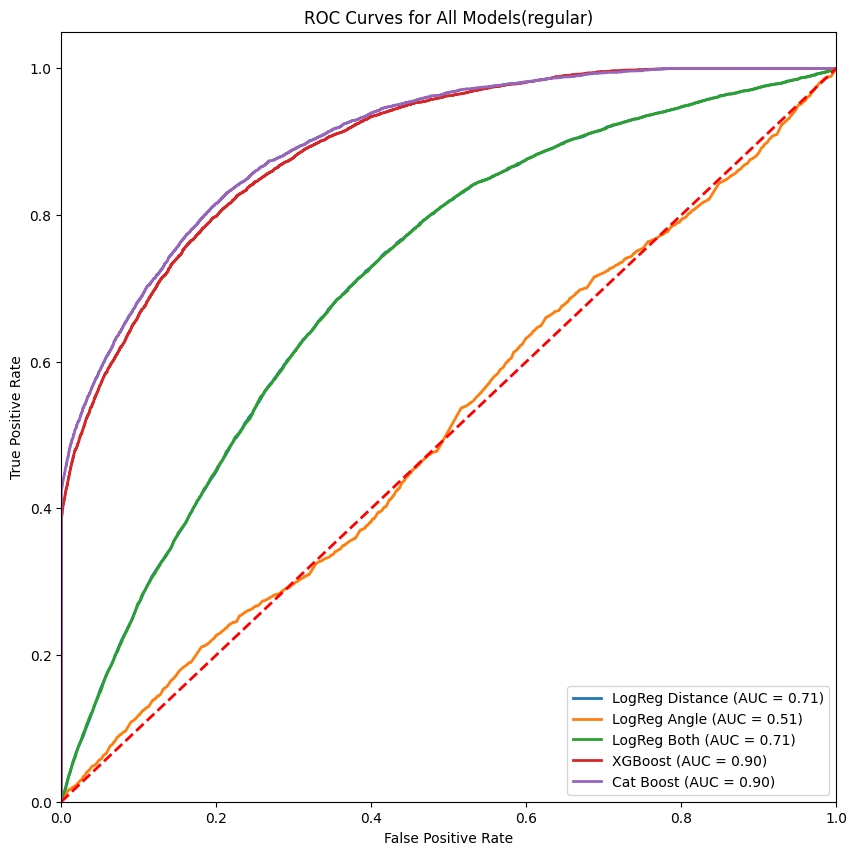

In [18]:
def plot_all_roc_curves(model_metrics, title, file_name):
    plt.figure(figsize=(10, 10))

    for label, metrics in model_metrics.items():
        fpr, tpr, roc_auc = metrics
        plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(file_name)
    plt.show()


model_metrics = {
    'LogReg Distance': (fpr_dist, tpr_dist, roc_auc_dist),
    'LogReg Angle': (fpr_angle, tpr_angle, roc_auc_angle),
    'LogReg Both': (fpr_both, tpr_both, roc_auc_both),
    'XGBoost': (fpr_xgb, tpr_xgb, roc_auc_xgb),
    'Cat Boost': (fpr_cb, tpr_cb, roc_auc_cb)
}
plot_all_roc_curves(model_metrics, 'ROC Curves for All Models(regular)', 'roc_all_models.png')

In [19]:
def prepare_bin_data(y_test, predictions, prediction_probabilities):
    """
    Helper to create bin data
    """
    bins = list(np.arange(0, 105, 5))
    bin_centers = list(np.arange(2.5, 100, 5.0))

    # Ensure predictions and probabilities are 1-dimensional
    predictions = np.ravel(predictions)
    if prediction_probabilities.ndim > 1:
        # Assuming positive class probabilities are in the second column
        prediction_probabilities = prediction_probabilities[:, 1]
    prediction_probabilities = prediction_probabilities * 100

    df_prob = pd.DataFrame({'goal_pred': predictions, 'goal': y_test, 'goal_probability': prediction_probabilities})
    df_prob['shot'] = 1
    df_prob['percentile'] = df_prob['goal_probability'].rank(pct=True) * 100
    df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels=bin_centers)

    df_prob_bined = df_prob.groupby('goal_perc_bins').sum(numeric_only=True).reset_index()
    df_prob_bined['goal_rate'] = df_prob_bined['goal'] / df_prob_bined['shot']
    df_prob_bined['goal_cum'] = df_prob_bined['goal'].cumsum() / df_prob_bined['goal'].sum()
    df_prob_bined['goal_cumsum'] = 1 - df_prob_bined['goal_cum']

    return df_prob_bined


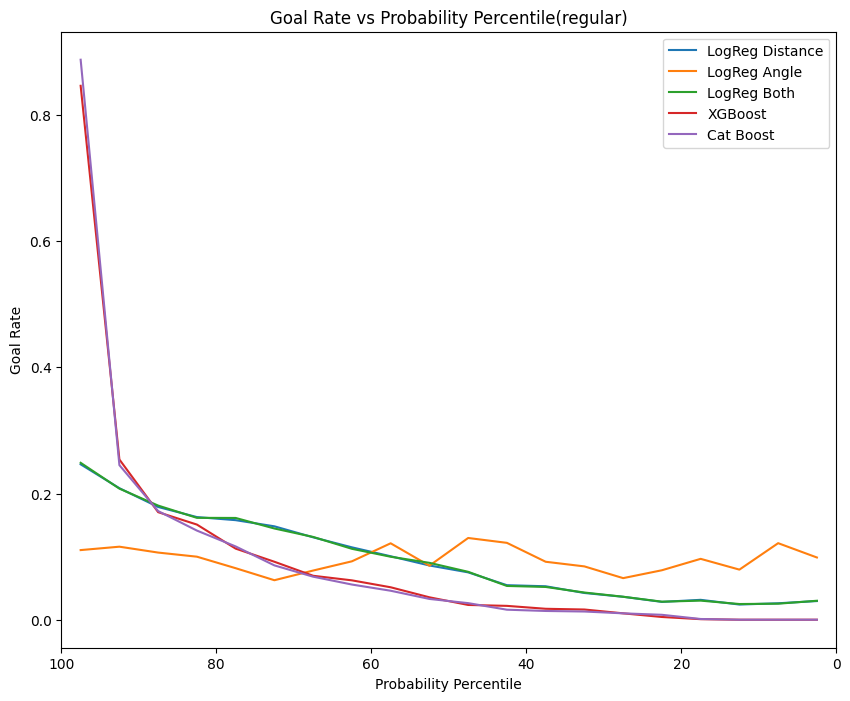

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


<Figure size 640x480 with 0 Axes>

In [20]:
# Flatten y_xgb_test to 1D
y_xgb_test_1d = np.ravel(y_xgb_test)


def plot_all_goal_rates(model_data, title, file_name, experiment):
    plt.figure(figsize=(10, 8))
    plt.title(title)

    for model_name, data in model_data.items():
        y_test, predictions, prediction_probabilities = data
        df_prob_bined = prepare_bin_data(y_test, predictions, prediction_probabilities)
        sns.lineplot(x='goal_perc_bins', y='goal_rate', data=df_prob_bined, label=model_name)

    plt.xlabel('Probability Percentile')
    plt.ylabel('Goal Rate')
    plt.legend(loc="best")
    plt.xlim(100, 0)
    plt.savefig(file_name)
    plt.show()
    experiment.log_figure(figure_name=file_name, step=None)

# For Logistic Regression Models
model_data = {
    'LogReg Distance': (y_log, y_pred_dist, y_proba_dist),
    'LogReg Angle': (y_log, y_pred_angle, y_proba_angle),
    'LogReg Both': (y_log, y_pred_both, y_proba_both),
    'XGBoost': (y_xgb_test_1d, y_pred_xgb, y_proba_xgb),
    'Cat Boost': (cb_y, y_pred_cb, y_proba_cb)
}



# Plotting the combined goal rate
plot_all_goal_rates(model_data, "Goal Rate vs Probability Percentile(regular)", "all_models_goal_rate.png", experiment)


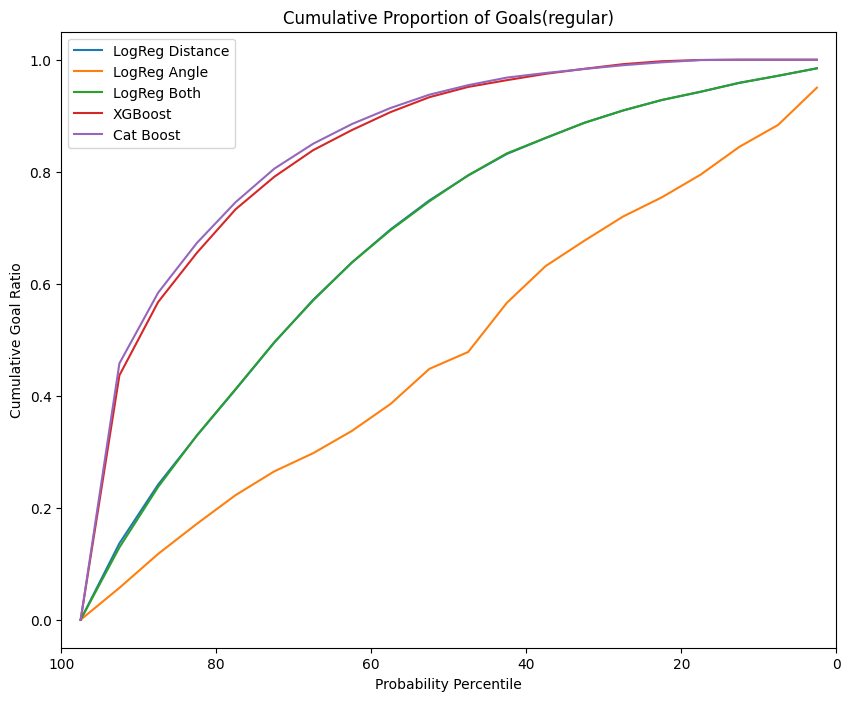

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


<Figure size 640x480 with 0 Axes>

In [21]:
def plot_all_cumulative_goals(model_data, title, file_name, experiment):
    plt.figure(figsize=(10, 8))
    plt.title(title)

    for model_name, data in model_data.items():
        y_test, predictions, prediction_probabilities = data
        df_prob_bined = prepare_bin_data(y_test, predictions, prediction_probabilities)
        sns.lineplot(x='goal_perc_bins', y='goal_cumsum', data=df_prob_bined, label=model_name)

    plt.xlabel('Probability Percentile')
    plt.ylabel('Cumulative Goal Ratio')
    plt.xticks(np.arange(0, 120, 20))
    plt.legend(loc="best")
    plt.xlim(100, 0)
    plt.savefig(file_name)
    plt.show()
    experiment.log_figure(figure_name=file_name, step=None)

# Plotting the combined cumulative goals
plot_all_cumulative_goals(model_data, "Cumulative Proportion of Goals(regular)", "all_models_cumulative_goals.png", experiment)


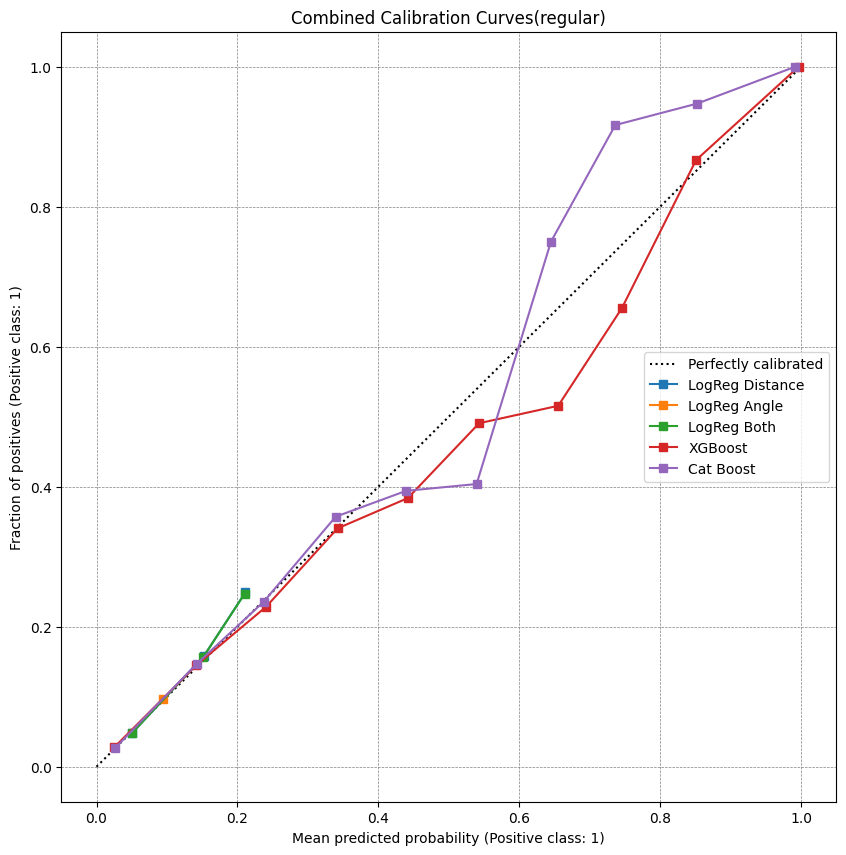

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


<Figure size 640x480 with 0 Axes>

In [22]:
def plot_combined_calibration_curve(model_data, title, file_name, experiment):
    _, ax = plt.subplots(figsize=(10, 10))
    plt.title(title)

    for model_name, data in model_data.items():
        y_test, prediction_probabilities = data

        # Check if prediction_probabilities is one-dimensional
        if len(prediction_probabilities.shape) == 1 or prediction_probabilities.shape[1] == 1:
            proba = prediction_probabilities.ravel()
        else:
            proba = prediction_probabilities[:, 1].ravel()

        display = CalibrationDisplay.from_predictions(y_test, proba, n_bins=10, ax=ax, name=model_name)

    plt.grid(color='gray', linestyle='--', linewidth=.5)
    plt.legend(loc="center right")
    plt.savefig(file_name)
    plt.show()
    experiment.log_figure(figure_name=file_name, step=None)

# Gather data for each model
model_data = {
    'LogReg Distance': (y_log, y_proba_dist),
    'LogReg Angle': (y_log, y_proba_angle),
    'LogReg Both': (y_log, y_proba_both),
    'XGBoost': (y_xgb_test, y_proba_xgb),
    'Cat Boost': (cb_y, y_proba_cb)
    }

# Plotting the combined calibration curve
plot_combined_calibration_curve(model_data, "Combined Calibration Curves(regular)", "combined_calibration_curves.png", experiment)


# Test on 2019/20 Playoff data

In [23]:
raw_data

,event_type,gameID,gameType,home,away,season,eventID,gameID_eventID,game_time,game_period,...,is_emptyNet,strength,distance_to_positive_goal,distance_to_negative_goal,goal_coordinate,shot_distance_to_goal,shot_angle,change_in_shot_angle,goal_rate_dist,goal_rate_angle
0,Shot,2020020180,R,New Jersey Devils,New York Rangers,20202021,11,2020020180_11,2021-03-05T00:10:40Z,1,...,0,NaN,35.846897,153.169840,84,35.846897,59.858614,0.0,0.002648,0.001586
1,Shot,2020020180,R,New Jersey Devils,New York Rangers,20202021,19,2020020180_19,2021-03-05T00:14:59Z,1,...,0,NaN,119.151164,49.365980,-84,49.365980,6.981057,0.0,0.001923,0.013596
2,Shot,2020020180,R,New Jersey Devils,New York Rangers,20202021,20,2020020180_20,2021-03-05T00:16:31Z,1,...,0,NaN,50.774009,127.882759,84,50.774009,-32.124998,0.0,0.001869,-0.002955
3,Goal,2020020180,R,New Jersey Devils,New York Rangers,20202021,23,2020020180_23,2021-03-05T00:19:10Z,1,...,0,Even,23.537205,145.086181,84,23.537205,12.264774,0.0,0.004033,0.007739
4,Shot,2020020180,R,New Jersey Devils,New York Rangers,20202021,26,2020020180_26,2021-03-05T00:20:40Z,1,...,0,NaN,50.596443,121.061968,84,50.596443,18.434949,0.0,0.001876,0.005149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387824,Shot,2016030153,P,Nashville Predators,Chicago Blackhawks,20162017,859,2016030153_859,2017-04-18T05:01:24Z,4,...,0,NaN,55.803226,127.349912,84,55.803226,36.253838,0.0,0.001701,0.002618
387825,Shot,2016030153,P,Nashville Predators,Chicago Blackhawks,20162017,861,2016030153_861,2017-04-18T05:03:14Z,4,...,0,NaN,159.078597,10.295630,-84,10.295630,29.054604,0.0,0.009219,0.003267
387826,Shot,2016030153,P,Nashville Predators,Chicago Blackhawks,20162017,864,2016030153_864,2017-04-18T05:05:35Z,4,...,0,NaN,117.004273,51.009803,-84,51.009803,-1.123303,0.0,0.001861,-0.084497
387827,Shot,2016030153,P,Nashville Predators,Chicago Blackhawks,20162017,867,2016030153_867,2017-04-18T05:06:20Z,4,...,0,NaN,62.297673,110.819673,84,62.297673,-18.725788,0.0,0.001524,-0.005069


In [24]:
def train_test_split_season(df, seasons_train=[20162017, 20172018, 20182019], season_test=20192020):
    df_train = df[df['gameType']=='R'][df['season'].isin(seasons_train)]
    df_test = df[df['gameType']=='P'][df['season'] == season_test]
    return df_train, df_test
df_train_P, df_test_P =train_test_split_season(raw_data)
print(df_train_P.shape)
print(df_test_P.shape)

(237314, 39)
(7403, 39)


<ipython-input-24-57aebc4ac9ed>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = df[df['gameType']=='R'][df['season'].isin(seasons_train)]
<ipython-input-24-57aebc4ac9ed>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = df[df['gameType']=='P'][df['season'] == season_test]


In [25]:
fe2 = FeatureEngineering()
x_train, y_train_P, xgb_test_P, y_xgb_test_P = fe2.adjustdata(df_train_P, df_test_P)
print(xgb_test_P.columns)

def align_columns(train_df, test_df):
    # Get missing columns in the training test
    missing_cols = set(train_df.columns) - set(test_df.columns)
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        test_df[c] = 0

    # Ensure the order of column in the test set is in the same order as in train set
    test_df = test_df[train_df.columns]

    return train_df, test_df

x_train, xgb_test_P = align_columns(x_train, xgb_test_P)
print(xgb_test_P.columns)

Index(['game_seconds', 'game_period', 'x_coordinate', 'y_coordinate',
       'shot_distance_to_goal', 'shot_angle', 'last_x_coordinate',
       'last_y_coordinate', 'time_from_last_event', 'distance_from_last_event',
       'rebound', 'speed', 'time_since_powerplay_started',
       'num_friendly_non_goalie_skaters', 'num_opposing_non_goalie_skaters',
       'last_event_Blocked Shot', 'last_event_Faceoff', 'last_event_Giveaway',
       'last_event_Goal', 'last_event_Hit', 'last_event_Missed Shot',
       'last_event_Penalty', 'last_event_Shot', 'last_event_Stoppage',
       'last_event_Takeaway', 'shot_type_Backhand', 'shot_type_Deflected',
       'shot_type_Slap Shot', 'shot_type_Snap Shot', 'shot_type_Tip-In',
       'shot_type_Wrap-around', 'shot_type_Wrist Shot'],
      dtype='object')
Index(['game_seconds', 'game_period', 'x_coordinate', 'y_coordinate',
       'shot_distance_to_goal', 'shot_angle', 'last_x_coordinate',
       'last_y_coordinate', 'time_from_last_event', 'distance_f

<ipython-input-8-c60a662b9039>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['last_event'] = pd.Categorical(x_test['last_event'])
<ipython-input-8-c60a662b9039>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['last_event'] = pd.Categorical(x_train['last_event'])


In [26]:
# data for logreg models
X_log_P = df_test_P[['shot_distance_to_goal','shot_angle']]
y_log_P = df_test_P['is_goal']

In [27]:
# data for ensemble model(best over all model)
feature_cols = ['x_coordinate', 'y_coordinate', 'last_x_coordinate',
       'last_y_coordinate', 'distance_from_last_event', 'last_event',
       'rebound', 'speed', 'time_since_powerplay_started',
       'num_friendly_non_goalie_skaters', 'num_opposing_non_goalie_skaters',
       'is_emptyNet', 'shot_type', 'shot_distance_to_goal',
       'shot_angle', 'change_in_shot_angle']
df_test_P.rebound = df_test_P.rebound.astype(int)
cb_X_P = df_test_P[feature_cols]
cb_y_P = df_test_P['is_goal']

In [28]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report

def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]  # Assuming the positive class is at index 1

    # Compute metrics
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    return y_pred, y_proba, fpr, tpr, roc_auc, precision, recall

# Evaluate logistic regression models
y_pred_dist, y_proba_dist, fpr_dist, tpr_dist, roc_auc_dist, precision_dist, recall_dist = evaluate_model(clf_dist, X_log_P[['shot_distance_to_goal']], y_log_P)
y_pred_angle, y_proba_angle, fpr_angle, tpr_angle, roc_auc_angle, precision_angle, recall_angle = evaluate_model(clf_angle, X_log_P[['shot_angle']], y_log_P)
y_pred_both, y_proba_both, fpr_both, tpr_both, roc_auc_both, precision_both, recall_both = evaluate_model(clf_dist_angle, X_log_P, y_log_P)
y_pred_xgb, y_proba_xgb, fpr_xgb, tpr_xgb, roc_auc_xgb, precision_xgb, recall_xgb = evaluate_model(xgb, xgb_test_P, y_xgb_test_P)
y_pred_cb, y_proba_cb, fpr_cb, tpr_cb, roc_auc_cb, precision_cb, recall_cb = evaluate_model(cb_clf, cb_X_P, cb_y_P)

In [29]:
def log_model_metrics(model, model_name, preds, y_test, experiment):

    # Calculate metrics
    metrics = {
        f"{model_name}_accuracy_playoff": accuracy_score(y_test, preds),
        f"{model_name}_f1_playoff": f1_score(y_test, preds),
        f"{model_name}_recall_playoff": recall_score(y_test, preds),
        f"{model_name}_precision_playoff": precision_score(y_test, preds)
    }
    # Log metrics
    experiment.log_metrics(metrics)
    print(metrics)
    # Optionally, return the metrics
    return metrics

# Mapping each model to its respective test dataset
model_test_data = {
    'Logistic Regression Distance': (clf_dist, y_pred_dist, y_log_P),
    'Logistic Regression Angle': (clf_angle, y_pred_angle, y_log_P),
    'Logistic Regression Both': (clf_dist_angle, y_pred_both, y_log_P),
    'XGBoost': (xgb, y_pred_xgb, y_xgb_test_P),
    'Cat Boost': (cb_clf, y_pred_cb, cb_y_P)
}

# Logging metrics and parameters for each model
for model_name, (model, preds, y_test) in model_test_data.items():
    print(f"Logging for {model_name}")
    log_model_metrics(model, model_name, preds, y_test, experiment)

Logging for Logistic Regression Distance
{'Logistic Regression Distance_accuracy_playoff': 0.912332838038633, 'Logistic Regression Distance_f1_playoff': 0.0, 'Logistic Regression Distance_recall_playoff': 0.0, 'Logistic Regression Distance_precision_playoff': 0.0}
Logging for Logistic Regression Angle
{'Logistic Regression Angle_accuracy_playoff': 0.912332838038633, 'Logistic Regression Angle_f1_playoff': 0.0, 'Logistic Regression Angle_recall_playoff': 0.0, 'Logistic Regression Angle_precision_playoff': 0.0}
Logging for Logistic Regression Both
{'Logistic Regression Both_accuracy_playoff': 0.912332838038633, 'Logistic Regression Both_f1_playoff': 0.0, 'Logistic Regression Both_recall_playoff': 0.0, 'Logistic Regression Both_precision_playoff': 0.0}
Logging for XGBoost
{'XGBoost_accuracy_playoff': 0.9469134134810212, 'XGBoost_f1_playoff': 0.5778732545649838, 'XGBoost_recall_playoff': 0.41448382126348227, 'XGBoost_precision_playoff': 0.9539007092198581}
Logging for Cat Boost
{'Cat Boost

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


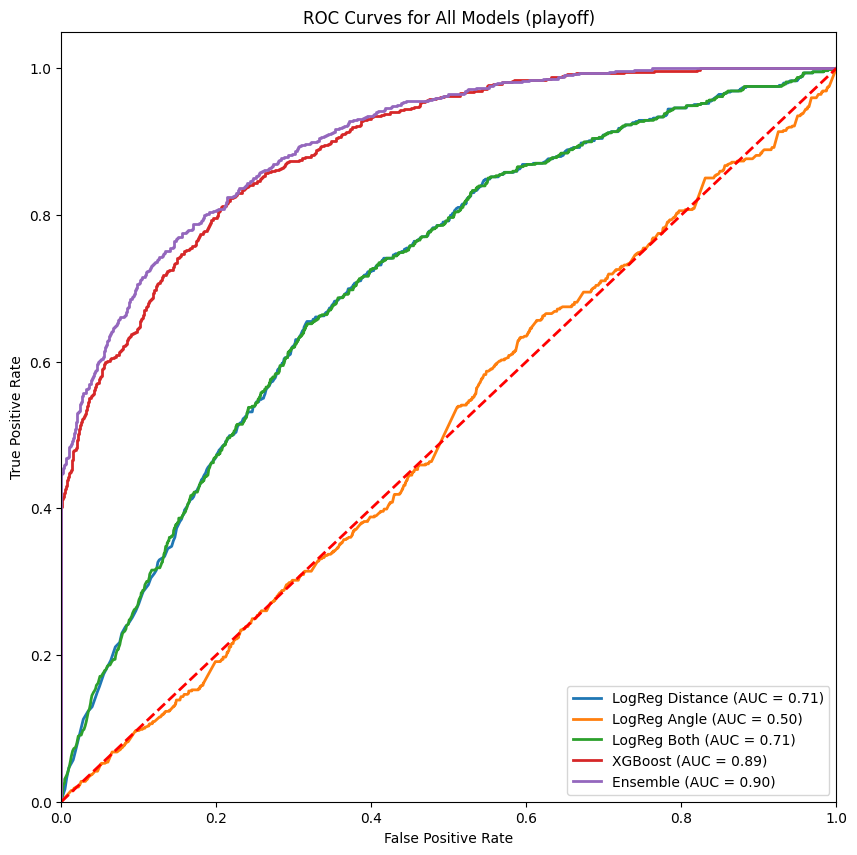

In [30]:
model_metrics = {
    'LogReg Distance': (fpr_dist, tpr_dist, roc_auc_dist),
    'LogReg Angle': (fpr_angle, tpr_angle, roc_auc_angle),
    'LogReg Both': (fpr_both, tpr_both, roc_auc_both),
    'XGBoost': (fpr_xgb, tpr_xgb, roc_auc_xgb),
    'Ensemble': (fpr_cb, tpr_cb, roc_auc_cb)
}
plot_all_roc_curves(model_metrics, 'ROC Curves for All Models (playoff)', 'roc_all_models_playoff.png')

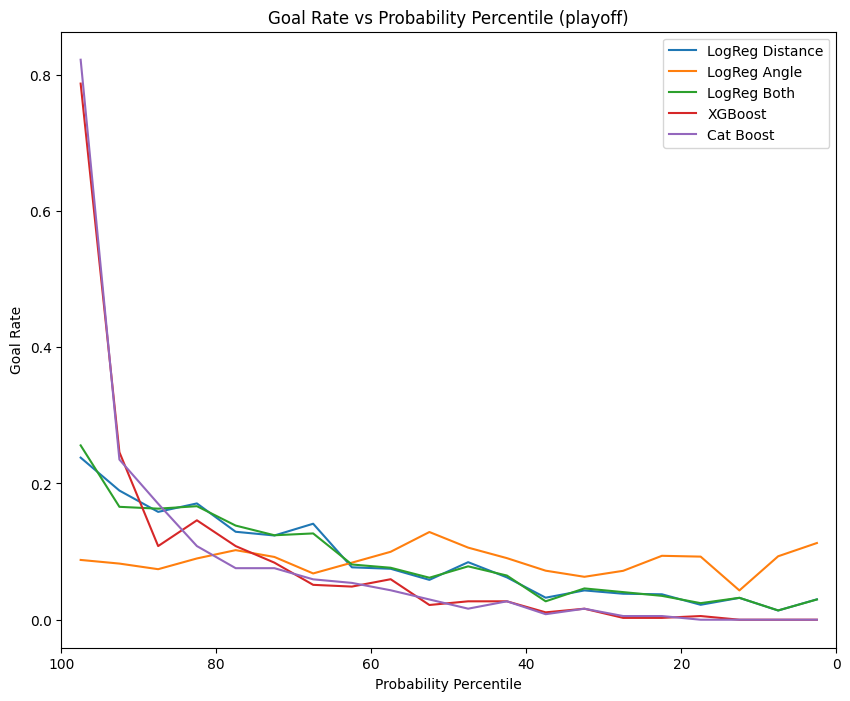

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


<Figure size 640x480 with 0 Axes>

In [31]:
# Flatten y_xgb_test to 1D
y_xgb_test_P_1d = np.ravel(y_xgb_test_P)

# For Logistic Regression Models
model_data_P = {
    'LogReg Distance': (y_log_P, y_pred_dist, y_proba_dist),
    'LogReg Angle': (y_log_P, y_pred_angle, y_proba_angle),
    'LogReg Both': (y_log_P, y_pred_both, y_proba_both),
    'XGBoost': (y_xgb_test_P_1d, y_pred_xgb, y_proba_xgb),
    'Cat Boost': (cb_y_P, y_pred_cb, y_proba_cb)
}


# Plotting the combined goal rate
plot_all_goal_rates(model_data_P, "Goal Rate vs Probability Percentile (playoff)", "all_models_goal_rate_playoff.png", experiment)

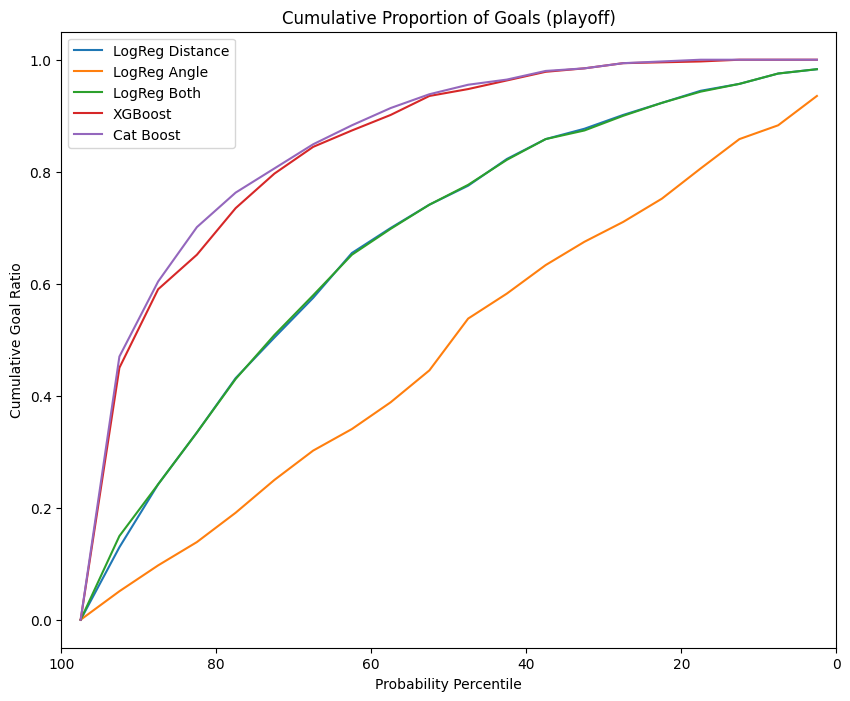

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


<Figure size 640x480 with 0 Axes>

In [32]:
# Plotting the combined cumulative goals
plot_all_cumulative_goals(model_data_P, "Cumulative Proportion of Goals (playoff)", "all_models_cumulative_goals_playoff.png", experiment)

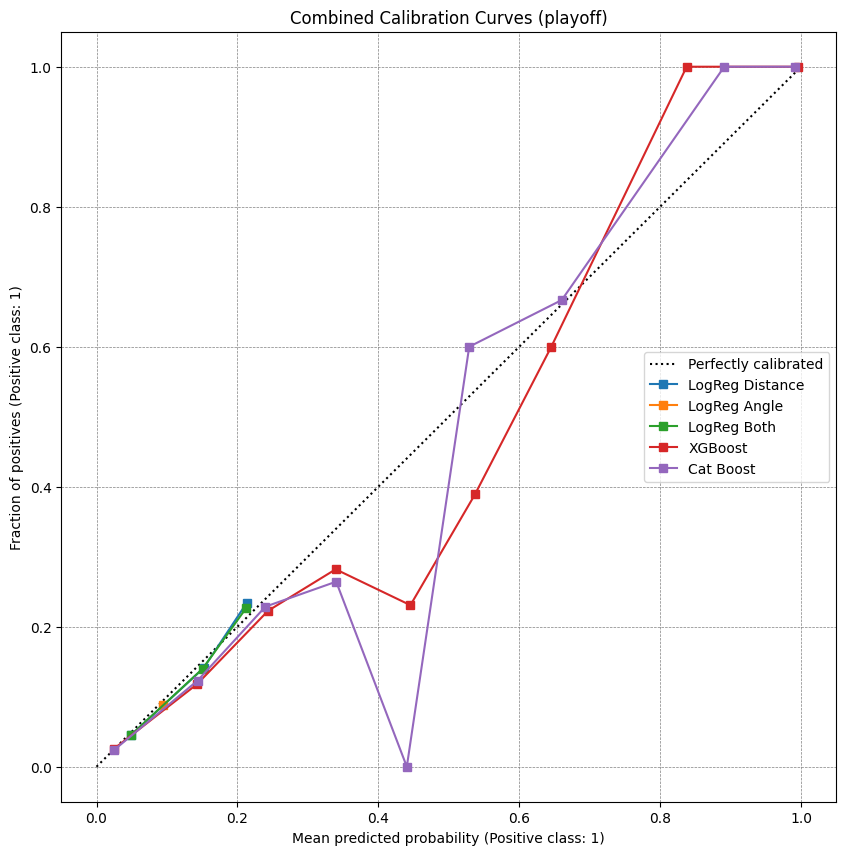

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


<Figure size 640x480 with 0 Axes>

In [34]:
# Gather data for each model
model_data = {
    'LogReg Distance': (y_log_P, y_proba_dist),
    'LogReg Angle': (y_log_P, y_proba_angle),
    'LogReg Both': (y_log_P, y_proba_both),
    'XGBoost': (y_xgb_test_P, y_proba_xgb),
    'Cat Boost': (cb_y_P, y_proba_cb)
    }

# Plotting the combined calibration curve
plot_combined_calibration_curve(model_data, "Combined Calibration Curves (playoff)", "combined_calibration_curves_playoff.png", experiment)

In [35]:
# Log the ROC curve plot to Comet.ml
experiment.log_image('roc_all_models.png', name="Test ROC Curve regular", overwrite=False)
experiment.log_image('roc_all_models_playoff.png', name="Test ROC Curve playoff", overwrite=False)
# Log the Goal Rate plot to Comet.ml
experiment.log_image('all_models_goal_rate.png', name="Test Goal Rate regualr", overwrite=False)
experiment.log_image('all_models_goal_rate_playoff.png', name="Test Goal Rate playoff", overwrite=False)
# Log the Cumulative Goal Rate plot to Comet.ml
experiment.log_image('all_models_cumulative_goals.png', name="Test Cumulative Goal Rate regular", overwrite=False)
experiment.log_image('all_models_cumulative_goals_playoff.png', name="Test Cumulative Goal Rate playoff", overwrite=False)
# Log the Calibration Curve plot to Comet.ml
experiment.log_image('combined_calibration_curves.png', name="Test Calibration Curve regular", overwrite=False)
experiment.log_image('combined_calibration_curves_playoff.png', name="Test Calibration Curve playoff", overwrite=False)

{'web': 'https://www.comet.com/api/image/download?imageId=0ba906eaf7034fc3b94a6dbfbe10486a&experimentKey=5457fb6c2cbd4947a8dc7c8b46d3e2c8',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=0ba906eaf7034fc3b94a6dbfbe10486a&experimentKey=5457fb6c2cbd4947a8dc7c8b46d3e2c8',
 'imageId': '0ba906eaf7034fc3b94a6dbfbe10486a'}

In [36]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mahmoodhegazy/nhl-data-science/5457fb6c2cbd4947a8dc7c8b46d3e2c8
COMET INFO:   Metrics:
COMET INFO:     Cat Boost_accuracy_playoff                     : 0.9512359854113197
COMET INFO:     Cat Boost_accuracy_regular                     : 0.944002195992314
COMET INFO:     Cat Boost_f1_playoff                           : 0.6171792152704135
COMET INFO:     Cat Boost_f1_regular                           : 0.5971731448763251
COMET INFO:     Cat Boost_precision_playoff                    : 0.9897959183673469
COMET INFO:     Cat Boost_precision_regular                    : 0.9872852233676976
COMET INFO:     Cat Boost_recall_playoff      